In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
print ("Training Data Shape: {}".format(train_dataset.data.shape))
print ("Targets Data Shape: {}".format(train_dataset.targets.shape))

Training Data Shape: torch.Size([60000, 28, 28])
Targets Data Shape: torch.Size([60000])


In [4]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [5]:
model = nn.Sequential(
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,10)
)
# No need for softmax activation function since its been pushed to nn.CrossEntropyLoss()

In [6]:
# Setting up for GPUs
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print (device)
model.to(device)

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [9]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1, 
                                           shuffle=True)
for x, y in tmp_loader:
  print(x)
  print(x.shape)
  print(y.shape)
  break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [10]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for epoch in range(n_epochs):
  train_loss = []
  for inputs,targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1,784)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criteria(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  train_loss = np.mean(train_loss)

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1,784)
    outputs = model(inputs)
    loss = criteria(outputs,targets)
    test_loss.append(loss.item())

  test_loss = np.mean(test_loss)

  train_losses[epoch] = train_loss
  test_losses[epoch] = test_loss

  print (f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss}, Test Loss: {test_loss}")

Epoch 1/10 Train Loss: 0.41727705701772594, Test Loss: 0.23314819961220404
Epoch 2/10 Train Loss: 0.19935936974818264, Test Loss: 0.16779338758250203
Epoch 3/10 Train Loss: 0.14292564451980438, Test Loss: 0.12771613538100185
Epoch 4/10 Train Loss: 0.11138735057861567, Test Loss: 0.10717280465178192
Epoch 5/10 Train Loss: 0.08885945384102717, Test Loss: 0.09759602702187398
Epoch 6/10 Train Loss: 0.07486498557420364, Test Loss: 0.08589067911549436
Epoch 7/10 Train Loss: 0.06184495124878533, Test Loss: 0.08108723946755658
Epoch 8/10 Train Loss: 0.05309480052989429, Test Loss: 0.07817353665772707
Epoch 9/10 Train Loss: 0.045102202100182835, Test Loss: 0.0749382778204229
Epoch 10/10 Train Loss: 0.03809618221711058, Test Loss: 0.07329799765330457


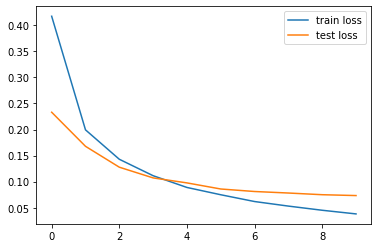

In [11]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [12]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1,784)
  outputs = model(inputs)
  _, predictions = torch.max(outputs,1) # axis = 1, along the rows.
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct / n_total
print ("Training Accuracy: {}".format(train_acc))

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1,784)
  outputs = model(inputs)
  _, predictions = torch.max(outputs,1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct / n_total
print ("Testing Accuracy: {}".format(test_acc))


Training Accuracy: 0.9931666666666666
Testing Accuracy: 0.9771


In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 968    0    1    1    1    1    2    1    3    2]
 [   0 1126    4    0    0    1    1    0    3    0]
 [   4    1 1006    2    3    0    2    4    9    1]
 [   0    0    7  978    1    9    0    5    4    6]
 [   0    0    6    1  960    0    4    2    1    8]
 [   2    0    0    4    1  875    3    1    4    2]
 [   5    3    2    1    4    3  939    0    1    0]
 [   3    5   10    4    0    1    0  995    2    8]
 [   3    0    4    4    4    4    2    3  948    2]
 [   1    4    0    6    9    5    1    5    2  976]]


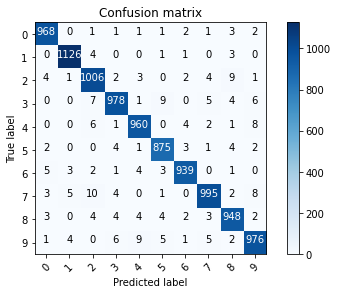

In [14]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  inputs = inputs.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

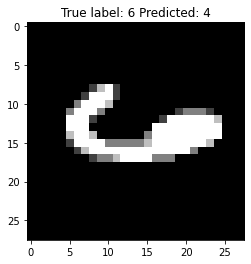

In [15]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));